# Library

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import joblib
import math
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from huggingface_hub import hf_hub_download
from datasets import load_dataset

# Dataset

In [50]:
df = pd.read_csv('train.csv')
df.head(4)

,order id,tanggal order,tanggal pengiriman,quantity,jenis customer,jenis product
0,ORD10000,2024-11-15,2024-11-16,2,Regular,Sulit
1,ORD10001,2023-07-27,2023-08-04,5,VIP,Mudah
2,ORD10002,2024-02-06,2024-02-08,3,Regular,Sulit
3,ORD10003,2023-12-28,2023-12-29,9,Regular,Sulit


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   order id            1000 non-null   object
 1   tanggal order       1000 non-null   object
 2   tanggal pengiriman  1000 non-null   object
 3   quantity            1000 non-null   int64 
 4   jenis customer      1000 non-null   object
 5   jenis product       1000 non-null   object
dtypes: int64(1), object(5)
memory usage: 47.0+ KB


# Pre-Processing

In [52]:
df['tanggal order'] = pd.to_datetime(df['tanggal order'], format='%Y-%m-%d')
df['tanggal pengiriman'] = pd.to_datetime(df['tanggal pengiriman'], format='%Y-%m-%d')
df.drop(columns=['order id'], inplace=True)
df.rename(columns={
    'quantity': 'kuantitas',
    'jenis product': 'jenis produk'},
    inplace=True
    )

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tanggal order       1000 non-null   datetime64[ns]
 1   tanggal pengiriman  1000 non-null   datetime64[ns]
 2   kuantitas           1000 non-null   int64         
 3   jenis customer      1000 non-null   object        
 4   jenis produk        1000 non-null   object        
dtypes: datetime64[ns](2), int64(1), object(2)
memory usage: 39.2+ KB


In [54]:
df.head()

,tanggal order,tanggal pengiriman,kuantitas,jenis customer,jenis produk
0,2024-11-15,2024-11-16,2,Regular,Sulit
1,2023-07-27,2023-08-04,5,VIP,Mudah
2,2024-02-06,2024-02-08,3,Regular,Sulit
3,2023-12-28,2023-12-29,9,Regular,Sulit
4,2025-01-30,2025-01-31,7,Regular,Mudah


In [55]:
df.duplicated().sum()

1

In [56]:
df[df.duplicated(keep=False)]

,tanggal order,tanggal pengiriman,kuantitas,jenis customer,jenis produk
423,2025-04-30,2025-05-05,10,Occasional,Sedang
785,2025-04-30,2025-05-05,10,Occasional,Sedang


In [57]:
df.isnull().sum()

tanggal order         0
tanggal pengiriman    0
kuantitas             0
jenis customer        0
jenis produk          0
dtype: int64

In [58]:
for col in df.select_dtypes(include=['object']).columns:
    print(f"Unique values in '{col}': {df[col].unique()}\n")

Unique values in 'jenis customer': ['Regular' 'VIP' 'Occasional' 'New' 'Loyal']

Unique values in 'jenis produk': ['Sulit' 'Mudah' 'Sedang']



In [59]:
for col in df.select_dtypes(include=['int', 'float']).columns:
    print(f"Unique values in '{col}': {df[col].unique()}\n")

Unique values in 'kuantitas': [ 2  5  3  9  7  8  1 10  4  6]



# Feature Engineering

In [60]:
df['jarak persiapan produk'] = (df['tanggal pengiriman'] - df['tanggal order']).dt.days

customer_score_map = {
    'Occasional': 0,
    'New': 1,
    'Regular': 2,
    'Loyal': 3,
    'VIP': 4
}

product_score_map = {
    'Mudah': 1,
    'Sedang': 2,
    'Sulit': 3
}

df['jenis customer'] = df['jenis customer'].map(customer_score_map)
df['jenis produk'] = df['jenis produk'].map(product_score_map)

def improved_priority_score(row):
    quantity = row['kuantitas']
    cust_score = row['jenis customer']
    prod_score = row['jenis produk']
    days_left = max(0, 10 - row['jarak persiapan produk'])  

    score = (
        (quantity / 10) * 25 +              
        (cust_score / 4) * 15 +              
        (prod_score / 3) * 20 +              
        (days_left / 10) * 40                
    )
    return round(score, 2)

df['skor output'] = df.apply(improved_priority_score, axis=1)

In [61]:
for column in df.select_dtypes(include=['int', 'float', 'object']).columns:
    print(df[column].value_counts().sort_index(), '\n')

kuantitas
1      83
2     108
3      98
4      81
5     109
6     105
7     103
8     120
9     101
10     92
Name: count, dtype: int64 

jenis customer
0    203
1    198
2    202
3    193
4    204
Name: count, dtype: int64 

jenis produk
1    317
2    333
3    350
Name: count, dtype: int64 

jarak persiapan produk
0    100
1     99
2     87
3    105
4     93
5    110
6    104
7     97
8    104
9    101
Name: count, dtype: int64 

skor output
17.17     1
19.67     1
20.92     1
21.92     1
23.17     1
         ..
93.33     1
95.00     2
96.00     1
97.50     1
100.00    1
Name: count, Length: 493, dtype: int64 



# EDA

In [62]:
df.describe()

,tanggal order,tanggal pengiriman,kuantitas,jenis customer,jenis produk,jarak persiapan produk,skor output
count,1000,1000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2024-07-07 10:35:02.400000,2024-07-11 23:52:48,5.602000,1.997000,2.033000,4.554000,56.831030
min,2023-07-09 00:00:00,2023-07-13 00:00:00,1.000000,0.000000,1.000000,0.000000,17.170000
25%,2024-01-09 00:00:00,2024-01-12 00:00:00,3.000000,1.000000,1.000000,2.000000,45.830000
50%,2024-07-04 00:00:00,2024-07-08 00:00:00,6.000000,2.000000,2.000000,5.000000,56.500000
75%,2025-01-04 06:00:00,2025-01-08 00:00:00,8.000000,3.000000,3.000000,7.000000,67.830000
max,2025-07-06 00:00:00,2025-07-09 00:00:00,10.000000,4.000000,3.000000,9.000000,100.000000
std,NaN,NaN,2.816297,1.421623,0.816442,2.869376,15.441029


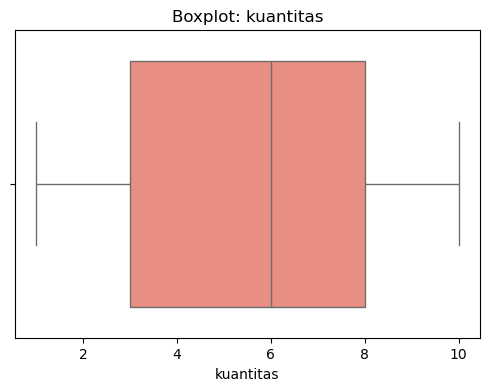

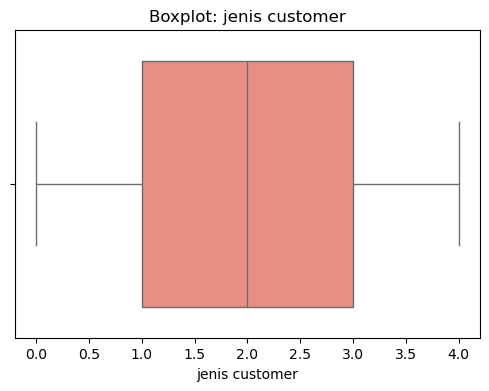

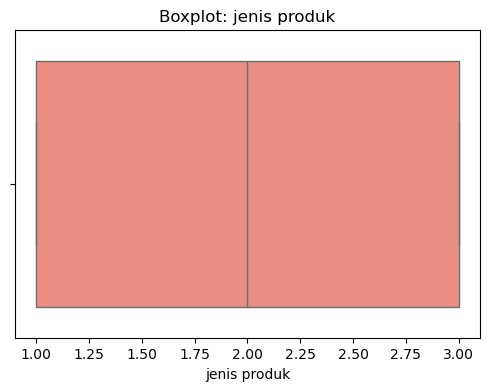

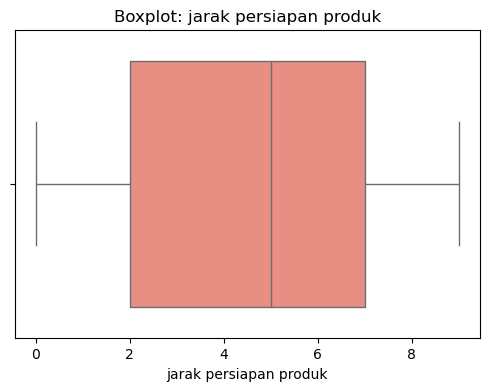

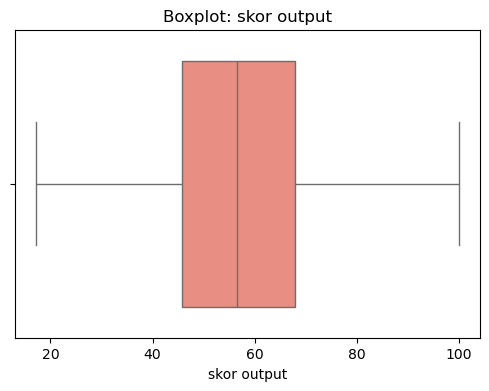

In [63]:
for col in df.select_dtypes(include=['int', 'float']).columns:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=df[col], color='salmon')
    plt.title(f'Boxplot: {col}')
    plt.show()

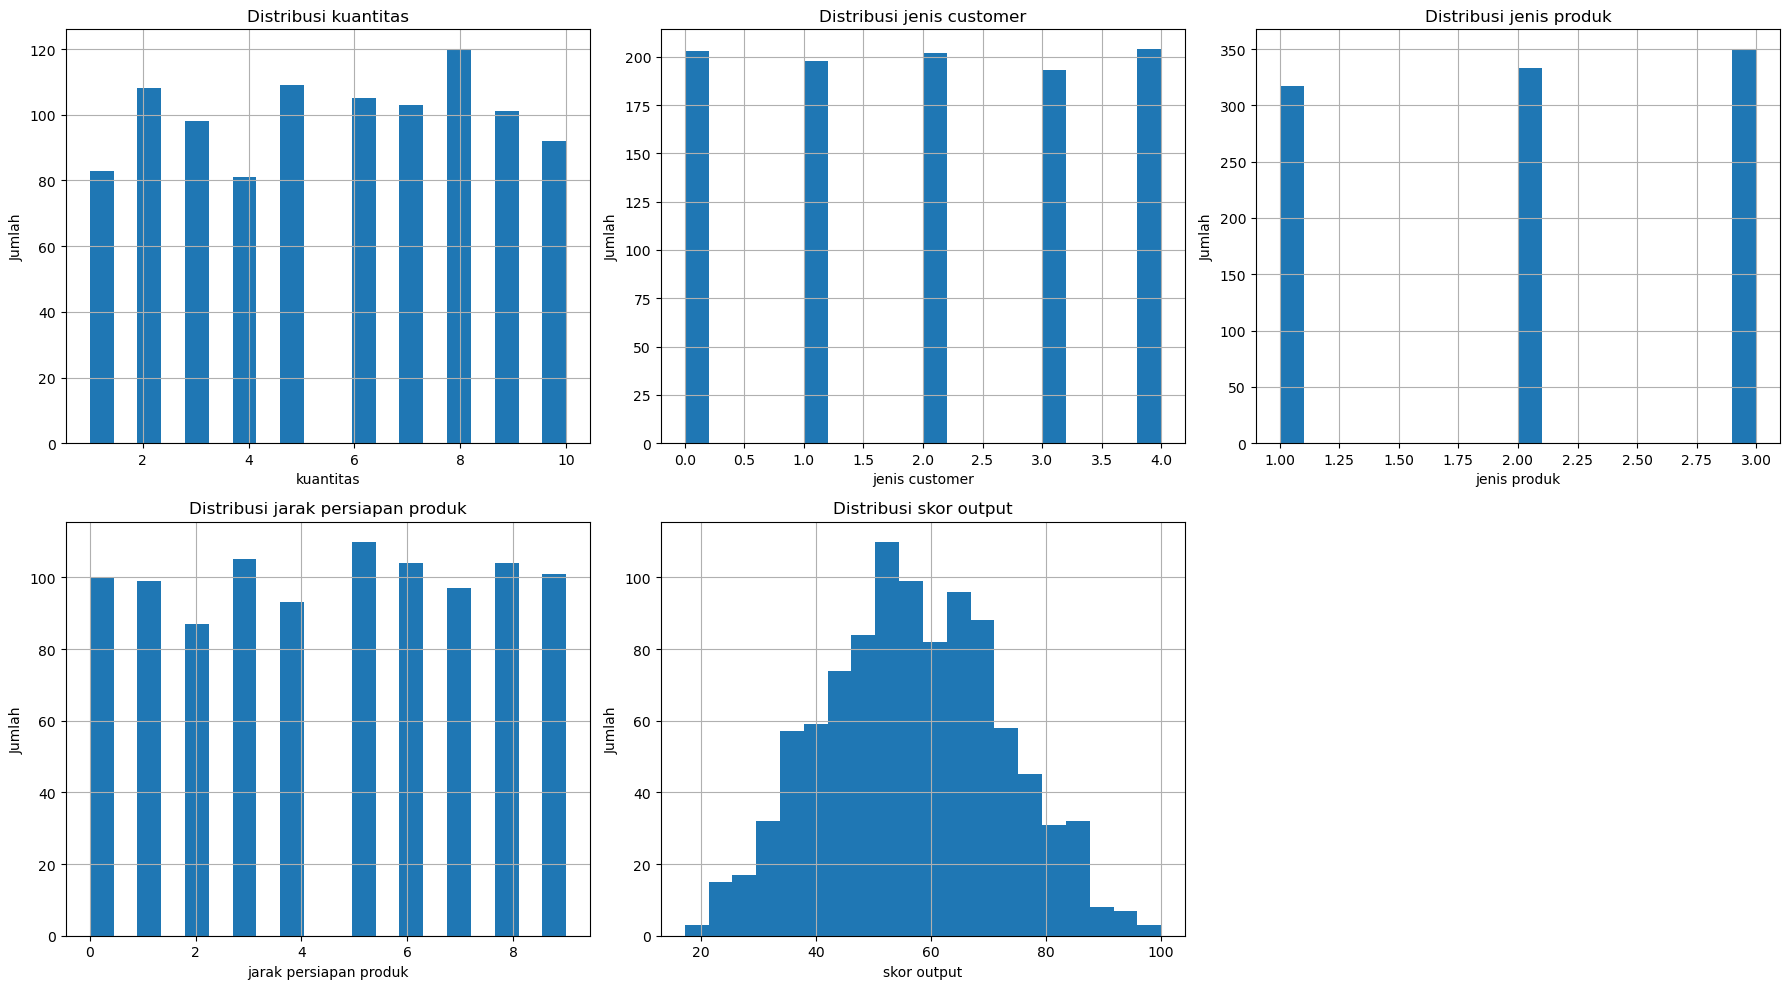

In [64]:
n_cols = 3
n_rows = math.ceil(len(df.select_dtypes(include=['int', 'float']).columns) / n_cols)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
axs = axs.flatten()  

for i, col in enumerate(df.select_dtypes(include=['int', 'float']).columns):
    df[col].hist(bins=20, ax=axs[i])
    axs[i].set_title(f'Distribusi {col}')
    axs[i].set_xlabel(col)
    axs[i].set_ylabel('Jumlah')

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


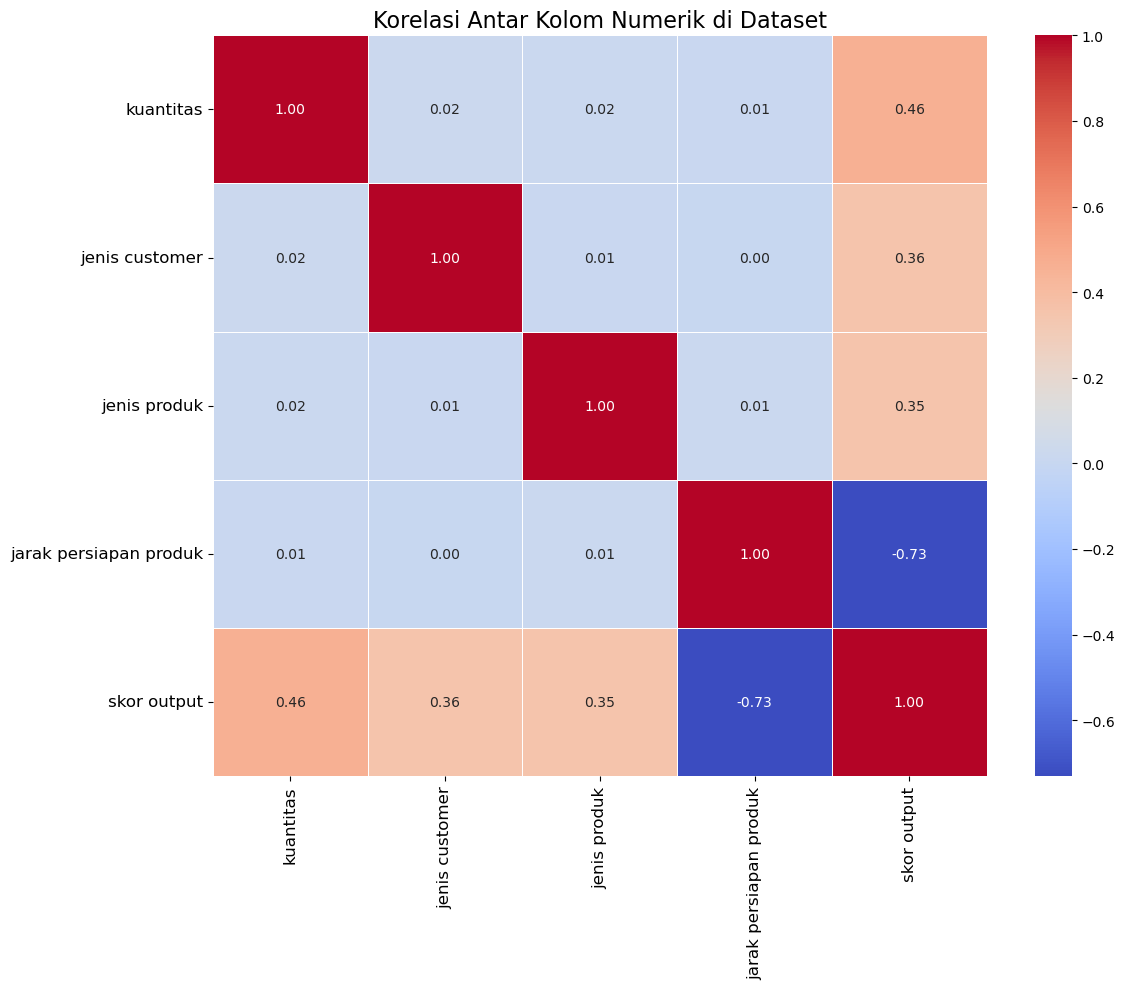

In [65]:
plt.figure(figsize=(12, 10))

correlation_matrix = df.corr(numeric_only=True, method='pearson')

sns.heatmap(correlation_matrix,
            annot=True,
            fmt=".2f",
            cmap='coolwarm',
            linewidths=0.5,
            linecolor='white')

plt.title('Korelasi Antar Kolom Numerik di Dataset', fontsize=16)
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12, rotation=0)
plt.tight_layout()
plt.show()

# Modeling dan Evaluasi

In [66]:
X = df[['kuantitas', 'jenis customer', 'jenis produk', 'jarak persiapan produk']]
y = df["skor output"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Random

In [67]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
model1 = RandomForestRegressor(
    n_estimators=200, 
    max_depth=10,
    min_samples_split=5, 
    min_samples_leaf=2,
    max_features='sqrt', 
    random_state=42
)
model1.fit(X_train_scaled, y_train)
y_pred = model1.predict(X_test_scaled)

print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", root_mean_squared_error(y_test, y_pred))

MSE: 4.959550371950856
R2 Score: 0.9781591011427605
MAE: 1.7739646777844285
RMSE: 2.2270047983672723


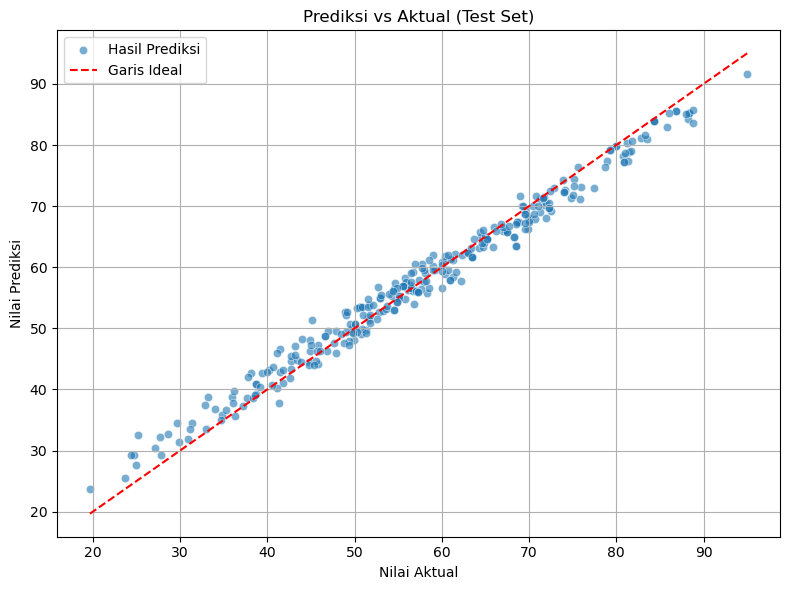

In [68]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, label='Hasil Prediksi')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Garis Ideal')
plt.xlabel("Nilai Aktual")
plt.ylabel("Nilai Prediksi")
plt.title("Prediksi vs Aktual (Test Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [69]:
y_train_pred = model1.predict(X_train_scaled)
y_test_pred = model1.predict(X_test_scaled)

print("Train MSE:", mean_squared_error(y_train, y_train_pred))
print("Train R²:", r2_score(y_train, y_train_pred))
print("Test MSE:", mean_squared_error(y_test, y_test_pred))
print("Test R²:", r2_score(y_test, y_test_pred))

Train MSE: 2.599314915865869
Train R²: 0.989280026757671
Test MSE: 4.959550371950856
Test R²: 0.9781591011427605


In [70]:
scores = cross_val_score(model1, X, y, cv=5, scoring='r2')
print("R² Score Cross-Validation:", scores)
print("Mean R²:", scores.mean())

R² Score Cross-Validation: [0.97685865 0.97840952 0.97650721 0.98294669 0.97676234]
Mean R²: 0.978296884413248


In [71]:
importances = model1.feature_importances_
feature_names = X.columns
feat_df = pd.DataFrame({'Fitur': feature_names, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False)
print(feat_df)

                    Fitur  Importance
3  jarak persiapan produk    0.557128
0               kuantitas    0.212722
2            jenis produk    0.116971
1          jenis customer    0.113179


In [72]:
hasil1 = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred
})

hasil1['Error'] = hasil1['Actual'] - hasil1['Predicted']
hasil1['Squared Error'] = hasil1['Error'] ** 2
hasil1['Absolute Error'] = abs(hasil1['Error'])
print(hasil1.head(10))

   Actual  Predicted     Error  Squared Error  Absolute Error
0   24.92  27.563276 -2.643276       6.986910        2.643276
1   50.75  49.042587  1.707413       2.915258        1.707413
2   47.67  47.591947  0.078053       0.006092        0.078053
3   49.67  50.084082 -0.414082       0.171464        0.414082
4   59.00  61.939287 -2.939287       8.639408        2.939287
5   54.25  55.373204 -1.123204       1.261588        1.123204
6   51.33  49.685886  1.644114       2.703110        1.644114
7   24.67  29.203676 -4.533676      20.554216        4.533676
8   81.50  78.819132  2.680868       7.187052        2.680868
9   64.50  64.962552 -0.462552       0.213955        0.462552


# Light

In [73]:
from lightgbm import LGBMRegressor

In [74]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
model2 = LGBMRegressor(
    objective='regression',
    metric='rmse',
    num_leaves=40,
    max_depth=8,
    learning_rate=0.05,
    n_estimators=300,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42
)
model2.fit(X_train_scaled, y_train)
y_pred = model2.predict(X_test_scaled)

print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", root_mean_squared_error(y_test, y_pred))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000656 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 4
[LightGBM] [Info] Start training from score 56.453686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

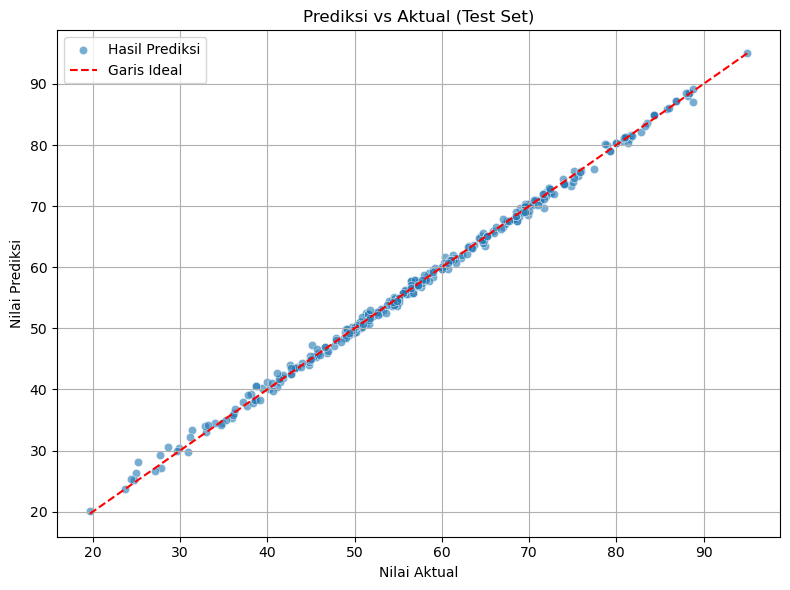

In [75]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, label='Hasil Prediksi')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Garis Ideal')
plt.xlabel("Nilai Aktual")
plt.ylabel("Nilai Prediksi")
plt.title("Prediksi vs Aktual (Test Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [76]:
y_train_pred = model2.predict(X_train_scaled)
y_test_pred = model2.predict(X_test_scaled)

print("Train MSE:", mean_squared_error(y_train, y_train_pred))
print("Train R²:", r2_score(y_train, y_train_pred))
print("Test MSE:", mean_squared_error(y_test, y_test_pred))
print("Test R²:", r2_score(y_test, y_test_pred))

Train MSE: 0.1978892868961137
Train R²: 0.9991838742402772
Test MSE: 0.4500073113086352
Test R²: 0.9980182549960785


In [77]:
scores = cross_val_score(model2, X, y, cv=5, scoring='r2')
print("R² Score Cross-Validation:", scores)
print("Mean R²:", scores.mean())

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 4
[LightGBM] [Info] Start training from score 56.646338
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [78]:
importances = model2.feature_importances_
feature_names = X.columns
feat_df = pd.DataFrame({'Fitur': feature_names, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False)
print(feat_df)

                    Fitur  Importance
3  jarak persiapan produk        1940
0               kuantitas        1918
1          jenis customer        1623
2            jenis produk        1130


In [79]:
hasil2 = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred
})

hasil2['Error'] = hasil2['Actual'] - hasil2['Predicted']
hasil2['Squared Error'] = hasil2['Error'] ** 2
hasil2['Absolute Error'] = abs(hasil2['Error'])
print(hasil2.head(10))

   Actual  Predicted     Error  Squared Error  Absolute Error
0   24.92  26.258607 -1.338607       1.791869        1.338607
1   50.75  50.050699  0.699301       0.489022        0.699301
2   47.67  47.065199  0.604801       0.365784        0.604801
3   49.67  49.925579 -0.255579       0.065321        0.255579
4   59.00  58.436755  0.563245       0.317245        0.563245
5   54.25  54.490028 -0.240028       0.057614        0.240028
6   51.33  50.859303  0.470697       0.221555        0.470697
7   24.67  25.143249 -0.473249       0.223965        0.473249
8   81.50  80.989170  0.510830       0.260948        0.510830
9   64.50  65.035538 -0.535538       0.286801        0.535538


# XGB

In [80]:
from xgboost import XGBRegressor

In [81]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
model3 = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=300,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42
)
model3.fit(X_train_scaled, y_train)
y_pred = model3.predict(X_test_scaled)

print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", root_mean_squared_error(y_test, y_pred))

MSE: 1.7120365207025736
R2 Score: 0.9924605228933572
MAE: 0.8798810844421386
RMSE: 1.3084481345099521


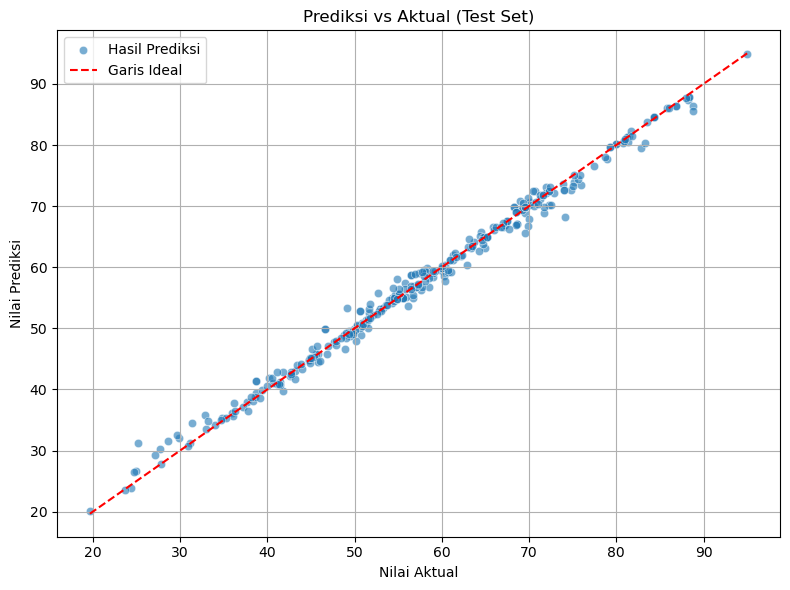

In [82]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, label='Hasil Prediksi')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Garis Ideal')
plt.xlabel("Nilai Aktual")
plt.ylabel("Nilai Prediksi")
plt.title("Prediksi vs Aktual (Test Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [83]:
scores = cross_val_score(model3, X, y, cv=5, scoring='r2')
print("R² Score Cross-Validation:", scores)
print("Mean R²:", scores.mean())

R² Score Cross-Validation: [0.99377812 0.9907378  0.99252664 0.99377837 0.99320918]
Mean R²: 0.9928060230729201


In [84]:
y_train_pred = model3.predict(X_train_scaled)
y_test_pred = model3.predict(X_test_scaled)

print("Train MSE:", mean_squared_error(y_train, y_train_pred))
print("Train R²:", r2_score(y_train, y_train_pred))
print("Test MSE:", mean_squared_error(y_test, y_test_pred))
print("Test R²:", r2_score(y_test, y_test_pred))

Train MSE: 0.061033926371805866
Train R²: 0.9997482867298663
Test MSE: 1.7120365207025736
Test R²: 0.9924605228933572


In [85]:
importances = model3.feature_importances_
feature_names = X.columns
feat_df = pd.DataFrame({'Fitur': feature_names, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False)
print(feat_df)

                    Fitur  Importance
3  jarak persiapan produk    0.458312
2            jenis produk    0.235516
0               kuantitas    0.159571
1          jenis customer    0.146601


In [86]:
hasil3 = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred
})

hasil3['Error'] = hasil3['Actual'] - hasil3['Predicted']
hasil3['Squared Error'] = hasil3['Error'] ** 2
hasil3['Absolute Error'] = abs(hasil3['Error'])
print(hasil3.head(10))

   Actual  Predicted     Error  Squared Error  Absolute Error
0   24.92  26.721012 -1.801012       3.243645        1.801012
1   50.75  48.883774  1.866226       3.482800        1.866226
2   47.67  47.734066 -0.064066       0.004104        0.064066
3   49.67  49.130833  0.539167       0.290701        0.539167
4   59.00  58.374538  0.625462       0.391202        0.625462
5   54.25  55.038567 -0.788567       0.621837        0.788567
6   51.33  51.316631  0.013369       0.000179        0.013369
7   24.67  26.572872 -1.902872       3.620922        1.902872
8   81.50  81.489182  0.010818       0.000117        0.010818
9   64.50  65.691437 -1.191437       1.419522        1.191437


# Perbandingan Grafik Antar Model

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 4
[LightGBM] [Info] Start training from score 56.453686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

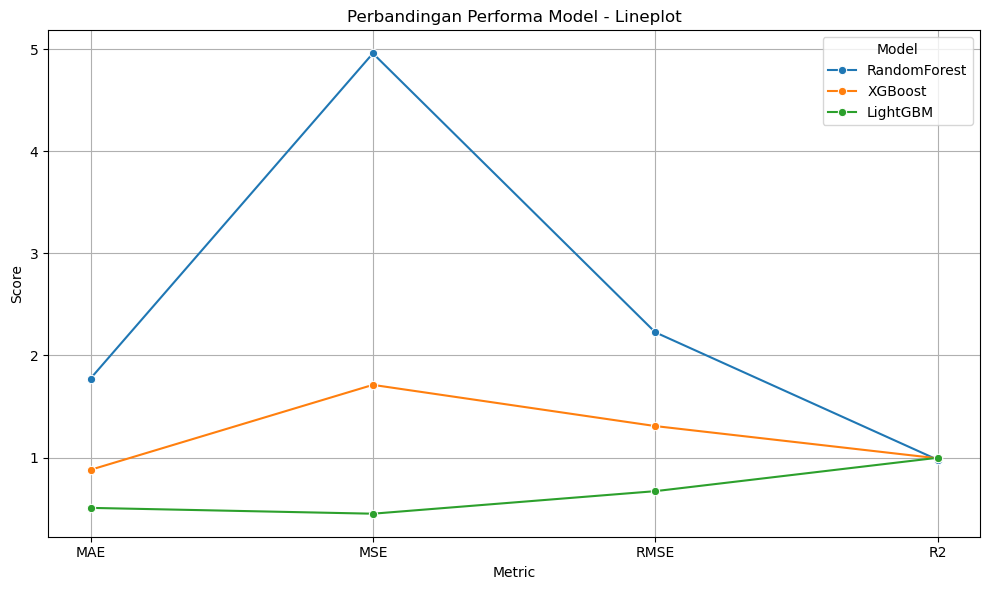

In [87]:
models = {
    'RandomForest':  RandomForestRegressor(
    n_estimators=200, 
    max_depth=10,
    min_samples_split=5, 
    min_samples_leaf=2,
    max_features='sqrt', 
    random_state=42
),
    'XGBoost': XGBRegressor(
    objective='reg:squarederror',
    n_estimators=300,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42
),
    'LightGBM': LGBMRegressor(
    objective='regression',
    metric='rmse',
    num_leaves=40,
    max_depth=8,
    learning_rate=0.05,
    n_estimators=300,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42
)
}

results = []

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    results.append({
        'Model': name,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    })

results_df = pd.DataFrame(results)

results_long = pd.melt(results_df, id_vars='Model', var_name='Metric', value_name='Score')

plt.figure(figsize=(10, 6))
sns.lineplot(data=results_long, x='Metric', y='Score', hue='Model', marker='o')
plt.title("Perbandingan Performa Model - Lineplot")
plt.grid(True)
plt.tight_layout()
plt.show()

# Testing

In [88]:
dataset = load_dataset("NararyaPutra/Dataset_ITBackburner")
df_test = dataset['test'].to_pandas()
df_test.head()

,order id,tanggal order,tanggal pengiriman,quantity,jenis customer,jenis product
0,TST20000,2025-07-07,2025-07-11,6,New,Sulit
1,TST20001,2025-07-07,2025-07-11,10,VIP,Sedang
2,TST20002,2025-07-07,2025-07-15,6,Occasional,Sulit
3,TST20003,2025-07-07,2025-07-16,4,New,Sedang
4,TST20004,2025-07-07,2025-07-07,3,New,Sedang


In [89]:
df_test['tanggal order'] = pd.to_datetime(df_test['tanggal order'], format='%Y-%m-%d')
df_test['tanggal pengiriman'] = pd.to_datetime(df_test['tanggal pengiriman'], format='%Y-%m-%d')
df_test.drop(columns=['order id'], inplace=True)
df_test.rename(columns={
    'quantity': 'kuantitas',
    'jenis product': 'jenis produk'},
    inplace=True
    )

In [90]:
df_test['jarak persiapan produk'] = (df_test['tanggal pengiriman'] - df_test['tanggal order']).dt.days

customer_score_map = {
    'Occasional': 0,
    'New': 1,
    'Regular': 2,
    'Loyal': 3,
    'VIP': 4
}

product_score_map = {
    'Mudah': 1,
    'Sedang': 2,
    'Sulit': 3
}

df_test['jenis customer'] = df_test['jenis customer'].map(customer_score_map)
df_test['jenis produk'] = df_test['jenis produk'].map(product_score_map)

def improved_priority_score(row):
    quantity = row['kuantitas']
    cust_score = row['jenis customer']
    prod_score = row['jenis produk']
    days_left = max(0, 10 - row['jarak persiapan produk'])  

    score = (
        (quantity / 10) * 25 +              
        (cust_score / 4) * 15 +              
        (prod_score / 3) * 20 +              
        (days_left / 10) * 40                
    )
    return round(score, 2)

df_test['skor output'] = df_test.apply(improved_priority_score, axis=1)

In [91]:
df_test.duplicated().sum()

27

In [92]:
df_test.isnull().sum()

tanggal order             0
tanggal pengiriman        0
kuantitas                 0
jenis customer            0
jenis produk              0
jarak persiapan produk    0
skor output               0
dtype: int64

In [93]:
model_path = hf_hub_download(
    repo_id="NararyaPutra/Model_ITBackburner",  
    filename="model_lightgbm.pkl",
    repo_type="model"
)

model = joblib.load(model_path)

In [94]:
X_new = df_test[['kuantitas', 'jenis customer', 'jenis produk', 'jarak persiapan produk']]
X_new_scaled = scaler.transform(X_new)
y_pred = model.predict(X_new_scaled)
y_true = df_test['skor output']

print("MSE:", mean_squared_error(y_true, y_pred))
print("R2 Score:", r2_score(y_true, y_pred))
print("MAE:", mean_absolute_error(y_true, y_pred))
print("RMSE:", root_mean_squared_error(y_true, y_pred))

MSE: 0.4278260937421448
R2 Score: 0.9983878628137792
MAE: 0.5036635933074721
RMSE: 0.6540841641120391


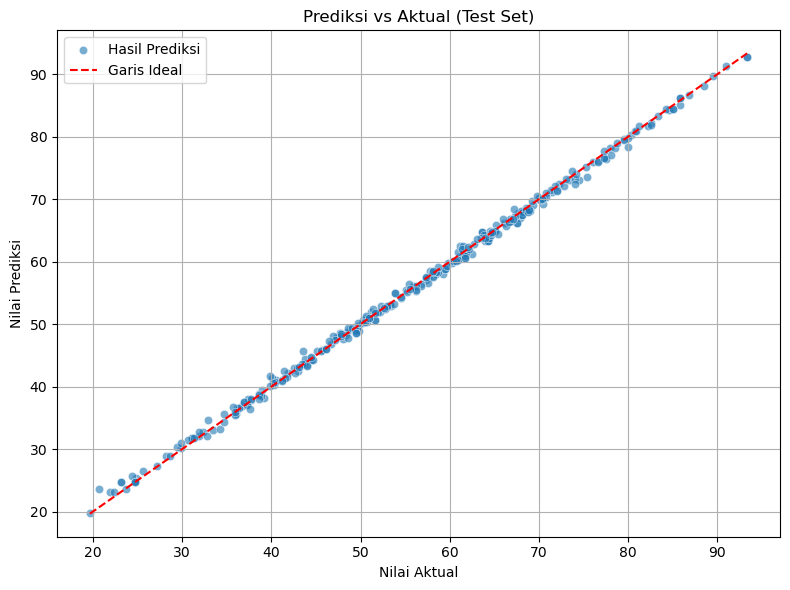

In [95]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_true, y=y_pred, alpha=0.6, label='Hasil Prediksi')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', label='Garis Ideal')
plt.xlabel("Nilai Aktual")
plt.ylabel("Nilai Prediksi")
plt.title("Prediksi vs Aktual (Test Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()